## Steps of Calculation

In [56]:
import galois
import numpy as np
import sys
sys.path.append('../../doubling-CSST/')
from convert_alist import readAlist
alistDirPath = "../../doubling-CSST/alistMats/GO03_self_dual/"
# The following are the parameters of the self-dual code included in the alistDirPath
length_dist_dict = {4:2, 6:2, 8:2, 10:2, 12:4, 14:4, 16:4, 18:4, 20:4, 22:6, 24:6, 26:6, 28:6, 30:6, 32:8, 34:6, 36:8, 38:8, 40:8, 42:8, 44:8, 46:8, 48:8, 50:8, 52:10, 54:8, 56:10, 58:10, 60:12, 62:10, 64:10}

n = 12 # all even lengths from 4 to 64
d = length_dist_dict[n]
F2 = galois.GF(2)
alistFilePath = alistDirPath + "n" + str(n) + "_d" + str(d) + ".alist"

GenMat = F2(readAlist(alistFilePath))
print("Generator matrix of the [n=%s,k=%s,d=%s] self-dual code:" % (n, n//2, d))
print(GenMat)

Generator matrix of the [n=12,k=6,d=4] self-dual code:
[[0 1 1 1 0 0 1 1 1 0 0 0]
 [0 1 1 0 0 1 1 1 0 0 1 0]
 [1 0 0 0 0 1 1 1 0 0 1 1]
 [0 0 1 0 0 1 1 0 0 1 1 1]
 [0 0 1 1 1 0 0 0 0 1 1 1]
 [0 1 1 1 0 0 1 0 0 1 1 0]]


In [57]:
import scipy.sparse

G_punctured = GenMat[:, :-1]  # Puncture the last column
print("Punctured code: [n=%s,k=%s]" % (G_punctured.shape[1], G_punctured.shape[0]))
H_punctured = G_punctured.null_space() # Parity-check matrix of the punctured code = generator matrix of the dual of the punctured code
print("Dual of the punctured code: [n=%s,k=%s]" % (H_punctured.shape[1], H_punctured.shape[0]))
Hx = Hz = scipy.sparse.csr_matrix(np.array(H_punctured, dtype=int))

print(type(Hx))
print(Hz.size)

Punctured code: [n=11,k=6]
Dual of the punctured code: [n=11,k=5]
<class 'scipy.sparse._csr.csr_matrix'>
22


In [58]:
from ldpc.bplsd_decoder import BpLsdDecoder
bias_factor = 0.0
num_shots = 10
error_rate = 0.1
lsd_order = 5
max_iter = 2

bp_lsd_x = BpLsdDecoder(
    Hx,
    error_rate=error_rate,
    bp_method = 'product_sum',
    max_iter = max_iter,
    schedule = 'serial',
    lsd_method = 'lsd_cs',
    lsd_order = lsd_order
)

bp_lsd_z = BpLsdDecoder(
    Hz,
    error_rate=error_rate,
    bp_method = 'product_sum',
    max_iter = max_iter,
    schedule = 'serial',
    lsd_method = 'lsd_cs',
    lsd_order = lsd_order
)

rZ = bias_factor / (1 + bias_factor)
rX = rY = (1 - rZ) / 2

error_x = np.random.choice(
    [0, 1], size=(num_shots, Hx.shape[1]), p=[1 - rX * error_rate, rX * error_rate]
)
error_y = np.random.choice(
    [0, 1], size=(num_shots, Hx.shape[1]), p=[1 - rY * error_rate, rY * error_rate]
)
error_z = np.random.choice(
    [0, 1], size=(num_shots, Hx.shape[1]), p=[1 - rZ * error_rate, rZ * error_rate]
)

In [59]:
error_x = (error_x + error_y) % 2
error_z = (error_z + error_y) % 2

syndromes_x = (error_z @ Hx.T) % 2
syndromes_z = (error_x @ Hz.T) % 2

Lx = Lz = np.ones((1, Hx.shape[1]), dtype=int)

# Decode the syndromes for X and Z errors separately
for i in range(num_shots):
	residual_error_x = (bp_lsd_x.decode(syndromes_x[i].T) + error_z[i]) % 2
	residual_error_z = (bp_lsd_z.decode(syndromes_z[i].T) + error_x[i]) % 2

	logical_error_x = (residual_error_x @ Lx.T) % 2
	logical_error_z = (residual_error_z @ Lz.T) % 2

	logical_error = (logical_error_x + logical_error_z) % 2
	if np.any(logical_error):
		print(f"Shot {i}: Logical Error Detected")
	else:
		print(f"Shot {i}: No Logical Error")

Shot 0: No Logical Error
Shot 1: No Logical Error
Shot 2: No Logical Error
Shot 3: No Logical Error
Shot 4: Logical Error Detected
Shot 5: No Logical Error
Shot 6: No Logical Error
Shot 7: No Logical Error
Shot 8: No Logical Error
Shot 9: No Logical Error


## Simulation for independent X error channel and Depolarizing error channel

In [60]:
import galois
import numpy as np
import scipy.sparse
import sys
sys.path.append('../../doubling-CSST/')
from convert_alist import readAlist
alistDirPath = "../../doubling-CSST/alistMats/GO03_self_dual/"
length_dist_dict = {4:2, 6:2, 8:2, 10:2, 12:4, 14:4, 16:4, 18:4, 20:4, 22:6, 24:6, 26:6, 28:6, 30:6, 32:8, 34:6, 36:8, 38:8, 40:8, 42:8, 44:8, 46:8, 48:8, 50:8, 52:10, 54:8, 56:10, 58:10, 60:12, 62:10, 64:10}

def self_dual_H(n):
	d = length_dist_dict[n]
	F2 = galois.GF(2)
	alistFilePath = alistDirPath + "n" + str(n) + "_d" + str(d) + ".alist"
	GenMat = F2(readAlist(alistFilePath))
	G_punctured = GenMat[:, :-1]
	H_punctured = G_punctured.null_space()
	H = scipy.sparse.csr_matrix(np.array(H_punctured, dtype=int))
	return H

In [61]:
from ldpc.bplsd_decoder import BpLsdDecoder

def initialize_decoder(Hx, Hz, error_rate, lsd_order, max_iter):
    bp_lsd_x = BpLsdDecoder(
        Hx,
        error_rate=error_rate,
        bp_method = 'product_sum',
        max_iter = max_iter,
        schedule = 'parallel',
        lsd_method = 'lsd_cs',
        lsd_order = lsd_order
    )

    bp_lsd_z = BpLsdDecoder(
        Hz,
        error_rate=error_rate,
        bp_method = 'product_sum',
        max_iter = max_iter,
        schedule = 'parallel',
        lsd_method = 'lsd_cs',
        lsd_order = lsd_order
    )
    return bp_lsd_x, bp_lsd_z

def generate_errors(num_shots, H, error_probability, bias_factor):
    rZ = bias_factor / (1 + bias_factor)
    rX = rY = (1 - rZ) / 2

    error_x = np.random.choice(
        [0, 1], size=(num_shots, H.shape[1]), p=[1 - rX * error_probability, rX * error_probability]
    )
    error_y = np.random.choice(
        [0, 1], size=(num_shots, H.shape[1]), p=[1 - rY * error_probability, rY * error_probability]
    )
    error_z = np.random.choice(
        [0, 1], size=(num_shots, H.shape[1]), p=[1 - rZ * error_probability, rZ * error_probability]
    )
    return error_x, error_y, error_z

In [62]:
def simulate_single_shot(Hx, Hz, Lx, Lz, error_x, error_y, error_z, decoder_x, decoder_z):
    """
    Simulates decoding failures considering both X and Z errors
    """
    error_x = (error_x + error_y) % 2
    error_z = (error_z + error_y) % 2
    
    syndromes_x = (error_z @ Hx.T) % 2
    syndromes_z = (error_x @ Hz.T) % 2

    # Decode the syndromes for X and Z errors separately    
    residual_error_x = (decoder_x.decode(syndromes_x.T) + error_z) % 2
    residual_error_z = (decoder_z.decode(syndromes_z.T) + error_x) % 2
    
    # Ensure decoding_x and error_x have the same shape before comparison
    logical_error_x = (residual_error_x @ Lx.T) % 2
    logical_error_z = (residual_error_z @ Lz.T) % 2

    return np.sum(logical_error_x + logical_error_z)

In [63]:
def run_simulation(ns, ps, bias_factor, max_iter, lsd_order, num_shots):
	log_errors_counts = []

	for n in ns:
		print(f"Simulating for n={n}...")
		Hx = Hz = self_dual_H(n)
		Lx = Lz = np.ones((1, Hx.shape[1]), dtype=int)

		log_errors = []

		for error_rate in ps:
			bp_lsd_x, bp_lsd_z = initialize_decoder(Hx, Hz, error_rate, lsd_order, max_iter)
			error_x, error_y, error_z = generate_errors(num_shots, Hx, error_rate, bias_factor)

			num_logical_errors = 0
			for i in range(num_shots):
				num_logical_errors += simulate_single_shot(Hx, Hz, Lx, Lz, error_x[i], error_y[i], error_z[i], bp_lsd_x, bp_lsd_z)
			
			logical_error_rate = num_logical_errors / num_shots
			log_errors.append(logical_error_rate)
		
		log_errors_counts.append(log_errors)

	return log_errors_counts

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def plot_logical_error_rates(ns, ps, bias_factors, log_errors_counts):
    """
    Plot the logical error rates for various distances and bias factors, and save the plot with a timestamped filename.
    """
    # Generate timestamp for filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f"logical_error_rates_{timestamp}.png"
    plt.figure(figsize=(12, 8))
    
    for i, log_errors in enumerate(log_errors_counts):
        plt.plot(ps, log_errors, marker='o', linestyle='-', label=f'n={ns[i]}')

    # Add break-even line
    plt.plot(ps, ps, linestyle='--', color='black', label='Break-even (y=x)')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Physical Error Rate (p)')
    plt.ylabel('Logical Error Rate')
    plt.title(f'Logical Error Rate vs. Physical Error Rate (Bias Factor: {bias_factors})')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, which="both", ls="--")
    
    # # Save the plot
    # plt.savefig(plot_filename)
    # print(f"Plot saved as {plot_filename}")
    
    plt.tight_layout()
    plt.show()

In [65]:
ns = [4, 6, 8, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]#, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
ps = np.logspace(-3, -1, 20).tolist()

lsd_order = 20
max_iter = 1000
bias_factor = 0.0
num_shots = 10000

log_errors_counts = run_simulation(ns, ps, bias_factor, max_iter, lsd_order, num_shots)

Simulating for n=4...
Simulating for n=6...
Simulating for n=8...
Simulating for n=12...
Simulating for n=14...
Simulating for n=16...
Simulating for n=18...
Simulating for n=20...
Simulating for n=22...
Simulating for n=24...
Simulating for n=26...
Simulating for n=28...
Simulating for n=30...


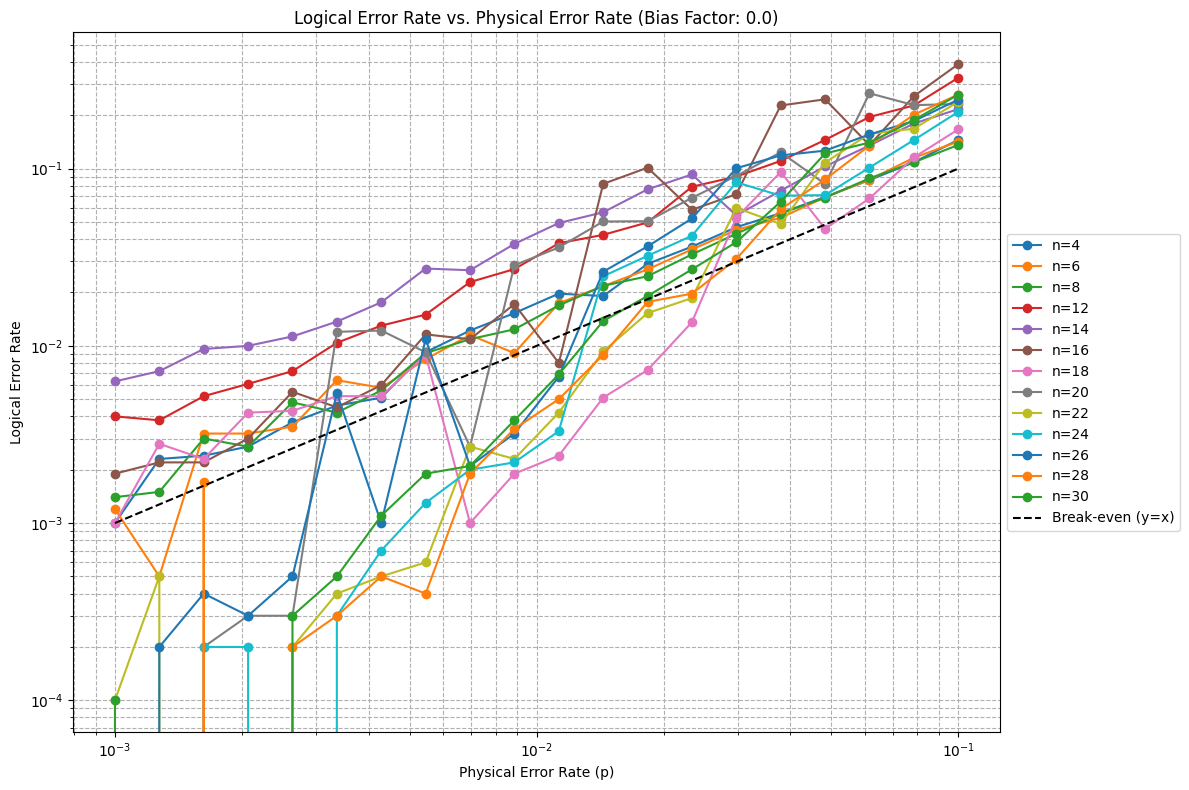

In [66]:
plot_logical_error_rates(ns, ps, bias_factor, log_errors_counts)

In [67]:
ns = [4, 6, 8, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]#, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
ps = np.logspace(-3, -1, 20).tolist()

lsd_order = 20
max_iter = 1000
bias_factor = 0.5
num_shots = 10000

log_errors_counts = run_simulation(ns, ps, bias_factor, max_iter, lsd_order, num_shots)

Simulating for n=4...
Simulating for n=6...
Simulating for n=8...
Simulating for n=12...
Simulating for n=14...
Simulating for n=16...
Simulating for n=18...
Simulating for n=20...
Simulating for n=22...
Simulating for n=24...
Simulating for n=26...
Simulating for n=28...
Simulating for n=30...


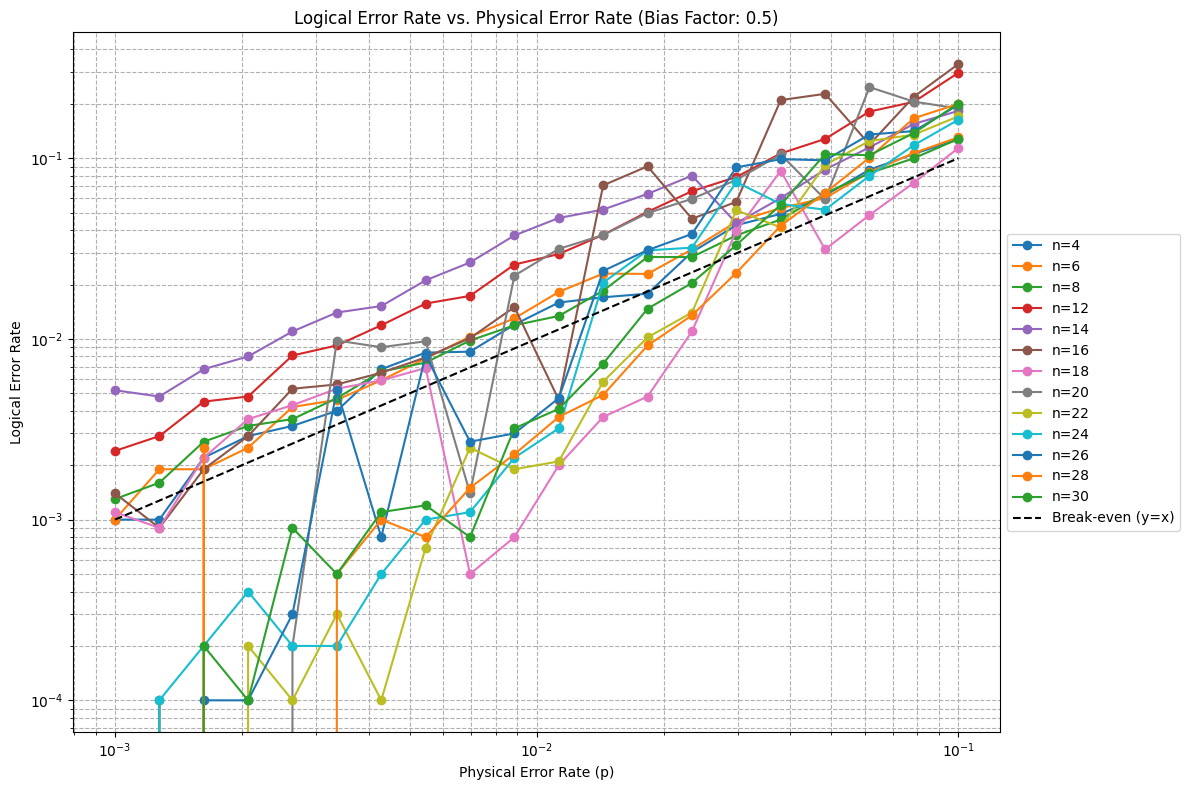

In [68]:
plot_logical_error_rates(ns, ps, bias_factor, log_errors_counts)